In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
   #     print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import scipy
import librosa.display
from IPython.display import Audio

import os
import sys
import cv2
import glob
import math
import random
import librosa
import zipfile
import numpy as np
import pandas as pd
from librosa import display as libdisplay
from tqdm.notebook import tqdm

In [3]:
#Placeholder for the training and test spectogram's images
#It is going to store the spec, we will shortly generate.
os.makedirs('Imgs/Train/', exist_ok=True)
os.makedirs('Imgs/Test/', exist_ok=True)

In [4]:
#will store our models here
os.makedirs('MODELS/', exist_ok=True)

In [5]:
!pip install librosa -U --quiet
!pip install torchaudio --quiet

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms
from torchvision import models
from keras.utils import to_categorical

In [8]:
import IPython.display as ipd
from matplotlib import pyplot as plt

In [9]:
seed = 79
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [10]:
def show_audio(ad):
    sig,sr = ad
    ipd.display(ipd.Audio(data=sig, rate=sr))

In [11]:
if torch.cuda.is_available():  # Tell PyTorch to use the GPU. 
 device = torch.device("cuda") 
 print('There are %d GPU(s) available.' % torch.cuda.device_count()) 
 print('We will use the GPU:', torch.cuda.get_device_name(0))# If not...
else:
 print('No GPU available, using the CPU instead.')
 device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [12]:
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    idea from this post:
    http://www.kaggle.com/c/emc-data-science/forums/t/2149/is-anyone-noticing-difference-betwen-validation-and-leaderboard-error/12209#post12209

    Parameters
    ----------
    y_true : array, shape = [n_samples]
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    return -1.0 / rows * vsota

In [13]:
def melspectogram_dB(file_path, cst=5, top_db=60.):
  row_sound, sr = librosa.load(file_path)
  sound = np.zeros((cst*sr,))

  if row_sound.shape[0] < cst*sr:
    sound[:row_sound.shape[0]] = row_sound[:]
  else:
    sound[:] = row_sound[:cst*sr]

  spec = librosa.feature.melspectrogram(sound, sr)
  spec_db = librosa.power_to_db(spec, top_db=top_db)

  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_img = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  
  return spec_img.astype(np.uint8)

def save_spec_image(spec_img, fname):
  cv2.imwrite(fname, spec_img)

In [14]:
zero = '../input/giz-nlp-agricultural-keyword-spotter/nlp_keywords_29Oct2020/nlp_keywords/omucungwa/6fbfcce2cf21419e97290f9e12934f65_0d02f150ae524c5ba0ea9752f00be1e0.wav'
#random_zero = zero+os.listdir(zero)[0]
Audio(zero)

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


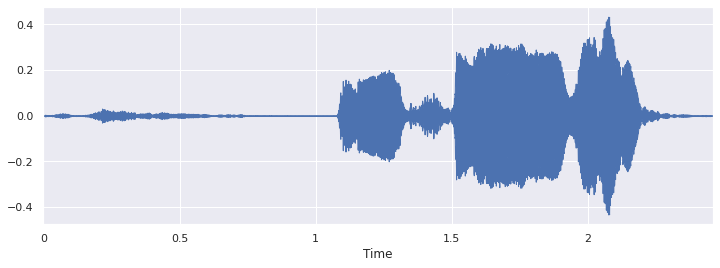

In [15]:
samples, sample_rate = librosa.load(zero)
#sample_rate, samples = scipy.io.wavfile.read(random_zero)
#row_sound, sr = librosa.load(file_path)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(samples.astype('float'), sr=sample_rate)
plt.show()

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


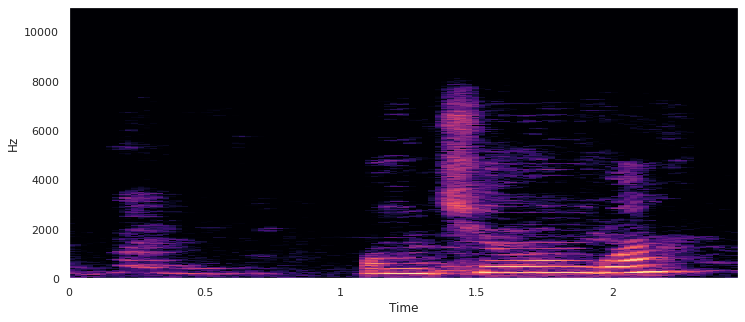

In [16]:
X = librosa.stft(samples.astype('float'))
Xdb = librosa.amplitude_to_db(X)
plt.figure(figsize=(12, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.show()

In [17]:
y_pitch_speed = samples.copy()
# you can change low and high here
length_change = np.random.uniform(low=0.8, high = 1)
speed_fac = 1.0  / length_change
print("resample length_change = ",length_change)
tmp = np.interp(np.arange(0,len(y_pitch_speed),speed_fac),np.arange(0,len(y_pitch_speed)),y_pitch_speed)
minlen = min(y_pitch_speed.shape[0], tmp.shape[0])
y_pitch_speed *= 0
y_pitch_speed[0:minlen] = tmp[0:minlen]
Audio(y_pitch_speed, rate=sample_rate)

resample length_change =  0.9001336252680763


In [18]:
y_pitch = samples.copy()
bins_per_octave = 12
pitch_pm = 2
pitch_change =  pitch_pm * 2*(np.random.uniform())   
print("pitch_change = ",pitch_change)
y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                      sample_rate, n_steps=3, 
                                      bins_per_octave=bins_per_octave)
Audio(y_pitch, rate=sample_rate)

pitch_change =  1.8722697037924605


In [19]:
y_speed = samples.copy()
speed_change = np.random.uniform(low=0.9,high=1.1)
print("speed_change = ",speed_change)
tmp = librosa.effects.time_stretch(y_speed.astype('float64'), speed_change)
minlen = min(y_speed.shape[0], tmp.shape[0])
y_speed *= 0 
y_speed[0:minlen] = tmp[0:minlen]
Audio(y_speed, rate=sample_rate)

speed_change =  1.0001565051284464


In [20]:
y_aug = samples.copy()
dyn_change = 4
print("dyn_change = ",dyn_change)
y_aug = y_aug * dyn_change
print(y_aug[:50])
print(samples[:50])
Audio(y_aug, rate=sample_rate)

dyn_change =  4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [21]:
y_noise = samples.copy()
# you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
Audio(y_noise, rate=sample_rate)

In [22]:
y_shift = samples.copy()
timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
print("timeshift_fac = ",timeshift_fac)
start = int(y_shift.shape[0] * timeshift_fac)
print(start)
if (start > 0):
    y_shift = np.pad(y_shift,(start,0),mode='constant')[0:y_shift.shape[0]]
else:
    y_shift = np.pad(y_shift,(0,-start),mode='constant')[0:y_shift.shape[0]]
Audio(y_shift, rate=sample_rate)

timeshift_fac =  -0.08085852750332229
-4386


In [23]:
y_hpss = librosa.effects.hpss(samples.astype('float64'))
print(y_hpss[1][:10])
print(samples[:10])
Audio(y_hpss[1], rate=sample_rate)

[-7.48270650e-05 -7.49249978e-05 -8.13883098e-05 -1.00574001e-04
 -1.05104801e-04 -9.02996104e-05 -7.90874124e-05 -6.81463913e-05
 -4.77643651e-05 -3.69620288e-05]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [24]:
samples[(samples > 200) | (samples < -200)]

array([], dtype=float32)

In [25]:
sampling=samples[(samples > 200) | (samples < -200)]
shifted_silent =sampling.tolist()+np.zeros((samples.shape[0]-sampling.shape[0])).tolist()
Audio(shifted_silent, rate=sample_rate)

/opt/conda/lib/python3.7/site-packages/IPython/lib/display.py:172: RuntimeWarning: invalid value encountered in true_divide
  scaled = data / normalization_factor * 32767


In [26]:
input_length = len(samples)
streching = samples.copy()
streching = librosa.effects.time_stretch(streching.astype('float'), 1.1)
if len(streching) > input_length:
    streching = streching[:input_length]
else:
    streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
Audio(streching, rate=sample_rate)

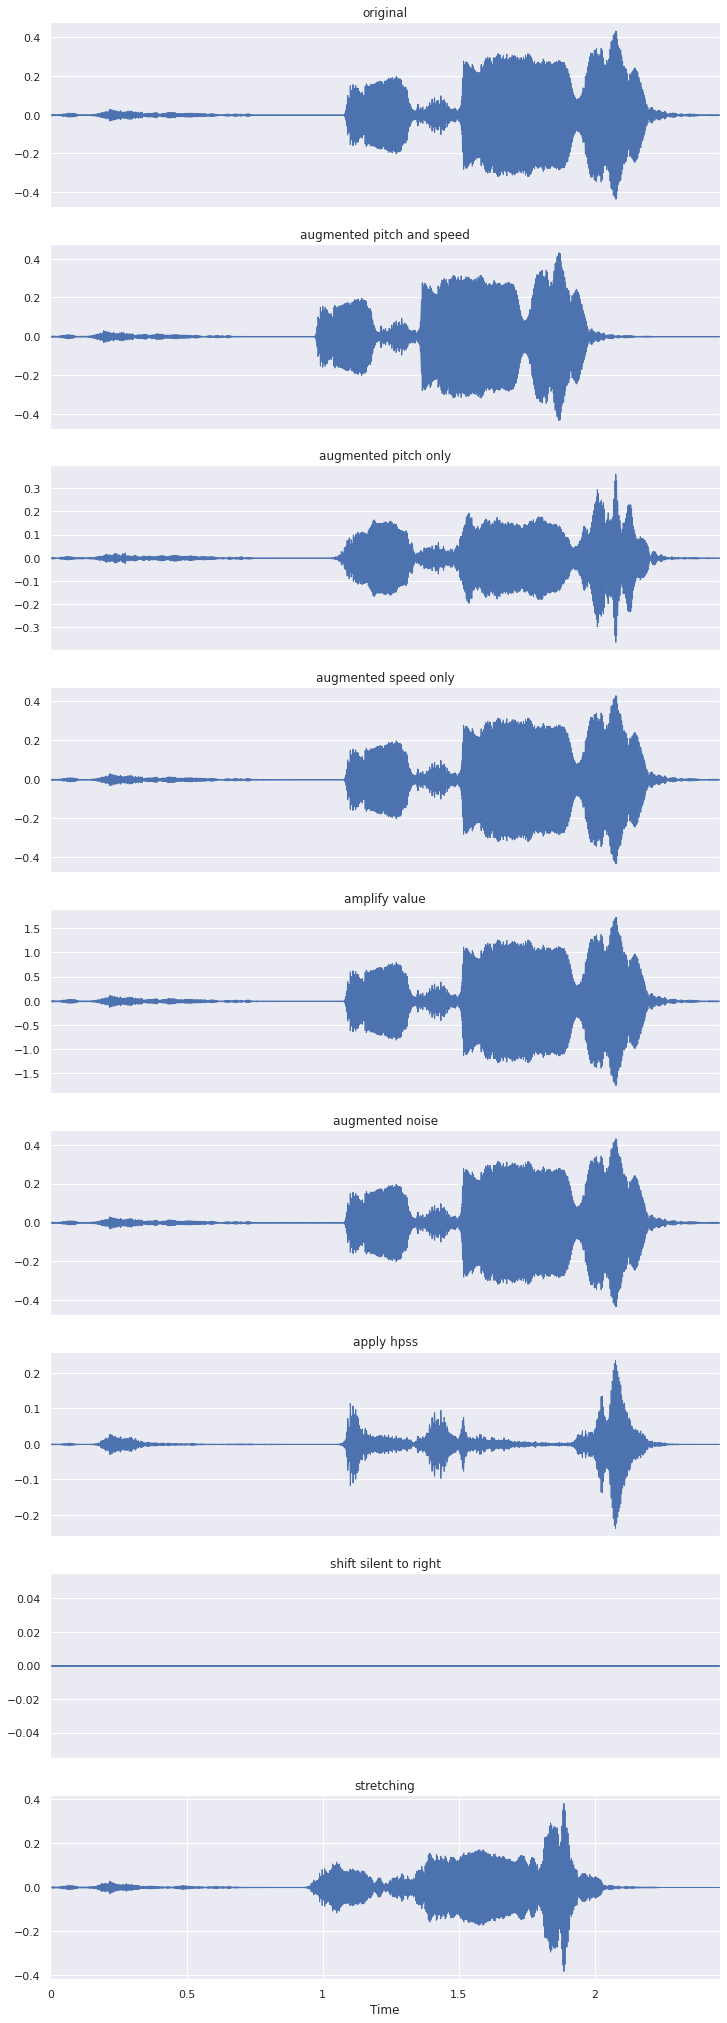

In [27]:
plt.figure(figsize=(12, 4*9))
plt.subplot(9, 1, 1)
librosa.display.waveplot(samples.astype('float'), sr=sample_rate,x_axis=None)
plt.title('original')
plt.subplot(9, 1, 2)
librosa.display.waveplot(y_pitch_speed.astype('float'), sr=sample_rate,x_axis=None)
plt.title('augmented pitch and speed')
plt.subplot(9, 1, 3)
librosa.display.waveplot(y_pitch, sr=sample_rate,x_axis=None)
plt.title('augmented pitch only')
plt.subplot(9, 1, 4)
librosa.display.waveplot(y_speed.astype('float'), sr=sample_rate,x_axis=None)
plt.title('augmented speed only')
plt.subplot(9, 1, 5)
librosa.display.waveplot(y_aug.astype('float'), sr=sample_rate,x_axis=None)
plt.title('amplify value')
plt.subplot(9, 1, 6)
librosa.display.waveplot(y_noise, sr=sample_rate,x_axis=None)
plt.title('augmented noise')
plt.subplot(9, 1, 7)
librosa.display.waveplot(y_hpss[1], sr=sample_rate,x_axis=None)
plt.title('apply hpss')
plt.subplot(9, 1, 8)
librosa.display.waveplot(np.array(shifted_silent).astype('float'), sr=sample_rate,x_axis=None)
plt.title('shift silent to right')
plt.subplot(9, 1, 9)
librosa.display.waveplot(streching, sr=sample_rate)
plt.title('stretching')
plt.show()

In [28]:
y_noise = samples.copy()
# you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
Audio(y_noise, rate=sample_rate)

In [29]:
import soundfile as sf
sf.write('test.wav', y_noise, 44100, 'PCM_24')

In [30]:
def sound2noise(file_path):
  #row_sound, sr = librosa.load(file_path)
  samples, sample_rate = librosa.load(file_path)
  y_noise = samples.copy()
  noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
  y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
  #sf.write('test.wav', y_noise, 44100, 'PCM_24')
  y_arr = y_noise
  return y_noise

In [31]:
def sound2hpss(file_path):
  #row_sound, sr = librosa.load(file_path)
  samples, sample_rate = librosa.load(file_path)
  y_hpss = librosa.effects.hpss(samples.astype('float64'))
  y_hpss=y_hpss[1]
  return y_hpss

In [32]:
def sound2pitch(file_path):
  #row_sound, sr = librosa.load(file_path)
  samples, sample_rate = librosa.load(file_path)
  y_pitch = samples.copy()
  bins_per_octave = 12 
  y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                      sample_rate, n_steps=3, 
                                      bins_per_octave=bins_per_octave)
  return y_pitch

In [33]:
def save2wav(fname, y_arr):
  sf.write(fname, y_arr, 44100, 'PCM_24')

In [34]:
#Placeholder for the training and test spectogram's images
#It is going to store the spec, we will shortly generate.
os.makedirs('Sound/Train/', exist_ok=True)
#os.makedirs('Imgs/Test/', exist_ok=True)

In [35]:
train_noise = pd.read_csv('../input/giz-nlp-agricultural-keyword-spotter/Train.csv')
train_noise.head()

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana
2,audio_files/F5POSU9.wav,obulwadde
3,audio_files/MMVDXG2.wav,nnyaanya
4,audio_files/9TVM96F.wav,pampu


In [36]:
import re

def clean_text(text):
    text = re.sub(r'audio_files/', '../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files/', text) # Remove path 
    return text
train_noise['fn'] = train_noise['fn'].apply(lambda x: clean_text(x))
train_noise.head()

,fn,label
0,../input/giz-nlp-agricultural-keyword-spotter/...,akawuka
1,../input/giz-nlp-agricultural-keyword-spotter/...,banana
2,../input/giz-nlp-agricultural-keyword-spotter/...,obulwadde
3,../input/giz-nlp-agricultural-keyword-spotter/...,nnyaanya
4,../input/giz-nlp-agricultural-keyword-spotter/...,pampu


In [37]:
# Add file names
train_noise['noise_name'] = './Sound/Train'+'_noise_' + train_noise['fn']
#sub['spec_name'] = 'Imgs/Test/'+sub['ID']+'.png'

In [38]:
train_noise.head()

,fn,label,noise_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,akawuka,./Sound/Train_noise_../input/giz-nlp-agricultu...
1,../input/giz-nlp-agricultural-keyword-spotter/...,banana,./Sound/Train_noise_../input/giz-nlp-agricultu...
2,../input/giz-nlp-agricultural-keyword-spotter/...,obulwadde,./Sound/Train_noise_../input/giz-nlp-agricultu...
3,../input/giz-nlp-agricultural-keyword-spotter/...,nnyaanya,./Sound/Train_noise_../input/giz-nlp-agricultu...
4,../input/giz-nlp-agricultural-keyword-spotter/...,pampu,./Sound/Train_noise_../input/giz-nlp-agricultu...


In [39]:
def clean_text(text):
    text = re.sub(r'./Sound/Train_noise_../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files', './Sound/Train/_noise_', text) # Remove path
    text = re.sub(r'_noise_/', '_noise_', text) # Remove path
    return text
train_noise['noise_name'] = train_noise['noise_name'].apply(lambda x: clean_text(x))
train_noise.head()

,fn,label,noise_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,akawuka,./Sound/Train/_noise_IV38R7F.wav
1,../input/giz-nlp-agricultural-keyword-spotter/...,banana,./Sound/Train/_noise_KM4SKWT.wav
2,../input/giz-nlp-agricultural-keyword-spotter/...,obulwadde,./Sound/Train/_noise_F5POSU9.wav
3,../input/giz-nlp-agricultural-keyword-spotter/...,nnyaanya,./Sound/Train/_noise_MMVDXG2.wav
4,../input/giz-nlp-agricultural-keyword-spotter/...,pampu,./Sound/Train/_noise_9TVM96F.wav


In [40]:
from tqdm.notebook import tqdm
#Training specs
for row in tqdm(train_noise.values):
  sound_path = row[0] #this corresponds to 'file_name'
  noise_name = row[2] #this corresponds to 'spec_name'

  y_arr = sound2noise(sound_path)
  #spec = spec_to_image(spec)
  save2wav(noise_name, y_arr)

In [41]:
train_noise.head()

,fn,label,noise_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,akawuka,./Sound/Train/_noise_IV38R7F.wav
1,../input/giz-nlp-agricultural-keyword-spotter/...,banana,./Sound/Train/_noise_KM4SKWT.wav
2,../input/giz-nlp-agricultural-keyword-spotter/...,obulwadde,./Sound/Train/_noise_F5POSU9.wav
3,../input/giz-nlp-agricultural-keyword-spotter/...,nnyaanya,./Sound/Train/_noise_MMVDXG2.wav
4,../input/giz-nlp-agricultural-keyword-spotter/...,pampu,./Sound/Train/_noise_9TVM96F.wav


In [42]:
train_noise=train_noise.drop(columns=['fn'])
train_noise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       1109 non-null   object
 1   noise_name  1109 non-null   object
dtypes: object(2)
memory usage: 17.5+ KB


In [43]:
train_noise = train_noise[["noise_name", "label"]]
train_noise.head()

,noise_name,label
0,./Sound/Train/_noise_IV38R7F.wav,akawuka
1,./Sound/Train/_noise_KM4SKWT.wav,banana
2,./Sound/Train/_noise_F5POSU9.wav,obulwadde
3,./Sound/Train/_noise_MMVDXG2.wav,nnyaanya
4,./Sound/Train/_noise_9TVM96F.wav,pampu


In [44]:
train_noise.rename(columns = {'noise_name':'fn'}, inplace = True) 
train_noise.head()

,fn,label
0,./Sound/Train/_noise_IV38R7F.wav,akawuka
1,./Sound/Train/_noise_KM4SKWT.wav,banana
2,./Sound/Train/_noise_F5POSU9.wav,obulwadde
3,./Sound/Train/_noise_MMVDXG2.wav,nnyaanya
4,./Sound/Train/_noise_9TVM96F.wav,pampu


In [45]:
# Add file names
train_noise['spec_name'] = './Imgs/Train/'+train_noise['fn']+'.png'

In [46]:
train_noise.head()

,fn,label,spec_name
0,./Sound/Train/_noise_IV38R7F.wav,akawuka,./Imgs/Train/./Sound/Train/_noise_IV38R7F.wav.png
1,./Sound/Train/_noise_KM4SKWT.wav,banana,./Imgs/Train/./Sound/Train/_noise_KM4SKWT.wav.png
2,./Sound/Train/_noise_F5POSU9.wav,obulwadde,./Imgs/Train/./Sound/Train/_noise_F5POSU9.wav.png
3,./Sound/Train/_noise_MMVDXG2.wav,nnyaanya,./Imgs/Train/./Sound/Train/_noise_MMVDXG2.wav.png
4,./Sound/Train/_noise_9TVM96F.wav,pampu,./Imgs/Train/./Sound/Train/_noise_9TVM96F.wav.png


In [47]:
def clean_text(text):
    text = re.sub(r'./Imgs/Train/./Sound/Train/', './Imgs/Train/', text) # Remove path
    text = re.sub(r'.wav.png', '.png', text) # Remove path
    return text
train_noise['spec_name'] = train_noise['spec_name'].apply(lambda x: clean_text(x))
train_noise.head()

,fn,label,spec_name
0,./Sound/Train/_noise_IV38R7F.wav,akawuka,./Imgs/Train/_noise_IV38R7F.png
1,./Sound/Train/_noise_KM4SKWT.wav,banana,./Imgs/Train/_noise_KM4SKWT.png
2,./Sound/Train/_noise_F5POSU9.wav,obulwadde,./Imgs/Train/_noise_F5POSU9.png
3,./Sound/Train/_noise_MMVDXG2.wav,nnyaanya,./Imgs/Train/_noise_MMVDXG2.png
4,./Sound/Train/_noise_9TVM96F.wav,pampu,./Imgs/Train/_noise_9TVM96F.png


In [48]:
train = pd.read_csv('../input/giz-nlp-agricultural-keyword-spotter/Train.csv')
import re

def clean_text(text):
    text = re.sub(r'audio_files/', '../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files/', text) # Remove path 
    return text
train['fn'] = train['fn'].apply(lambda x: clean_text(x))
# Add file names
train['spec_name'] = './Imgs/Train'+train['fn']+'.png'
#sub['spec_name'] = 'Imgs/Test/'+sub['ID']+'.png'
def clean_text(text):
    text = re.sub(r'./Imgs/Train../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files', './Imgs/Train/', text) # Remove path
    text = re.sub(r'.wav.png', '.png', text) # Remove path
    return text
train['spec_name'] = train['spec_name'].apply(lambda x: clean_text(x))
train.head()

,fn,label,spec_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,akawuka,./Imgs/Train//IV38R7F.png
1,../input/giz-nlp-agricultural-keyword-spotter/...,banana,./Imgs/Train//KM4SKWT.png
2,../input/giz-nlp-agricultural-keyword-spotter/...,obulwadde,./Imgs/Train//F5POSU9.png
3,../input/giz-nlp-agricultural-keyword-spotter/...,nnyaanya,./Imgs/Train//MMVDXG2.png
4,../input/giz-nlp-agricultural-keyword-spotter/...,pampu,./Imgs/Train//9TVM96F.png


In [49]:
train_hpss = pd.read_csv('../input/giz-nlp-agricultural-keyword-spotter/Train.csv')
train_hpss.head()

def clean_text(text):
    text = re.sub(r'audio_files/', '../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files/', text) # Remove path 
    return text
train_hpss['fn'] = train_hpss['fn'].apply(lambda x: clean_text(x))
# Add file names
train_hpss['hpss_name'] = './Sound/Train'+'_hpss_' + train_hpss['fn']
def clean_text(text):
    text = re.sub(r'./Sound/Train_hpss_../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files', './Sound/Train/_hpss_', text) # Remove path
    text = re.sub(r'_hpss_/', '_hpss_', text) # Remove path
    return text
train_hpss['hpss_name'] = train_hpss['hpss_name'].apply(lambda x: clean_text(x))
train_hpss.head()


,fn,label,hpss_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,akawuka,./Sound/Train/_hpss_IV38R7F.wav
1,../input/giz-nlp-agricultural-keyword-spotter/...,banana,./Sound/Train/_hpss_KM4SKWT.wav
2,../input/giz-nlp-agricultural-keyword-spotter/...,obulwadde,./Sound/Train/_hpss_F5POSU9.wav
3,../input/giz-nlp-agricultural-keyword-spotter/...,nnyaanya,./Sound/Train/_hpss_MMVDXG2.wav
4,../input/giz-nlp-agricultural-keyword-spotter/...,pampu,./Sound/Train/_hpss_9TVM96F.wav


In [50]:
from tqdm.notebook import tqdm
#Training specs
for row in tqdm(train_hpss.values):
  sound_path = row[0] #this corresponds to 'file_name'
  hpss_name = row[2] #this corresponds to 'spec_name'

  y_arr = sound2hpss(sound_path)
  #spec = spec_to_image(spec)
  save2wav(hpss_name, y_arr)

In [51]:
train_hpss=train_hpss.drop(columns=['fn'])
train_hpss = train_hpss[["hpss_name", "label"]]
train_hpss.rename(columns = {'hpss_name':'fn'}, inplace = True) 
# Add file names
train_hpss['spec_name'] = './Imgs/Train/'+train_hpss['fn']+'.png'

def clean_text(text):
    text = re.sub(r'./Imgs/Train/./Sound/Train/', './Imgs/Train/', text) # Remove path
    text = re.sub(r'.wav.png', '.png', text) # Remove path
    return text
train_hpss['spec_name'] = train_hpss['spec_name'].apply(lambda x: clean_text(x))
train_hpss.head()

,fn,label,spec_name
0,./Sound/Train/_hpss_IV38R7F.wav,akawuka,./Imgs/Train/_hpss_IV38R7F.png
1,./Sound/Train/_hpss_KM4SKWT.wav,banana,./Imgs/Train/_hpss_KM4SKWT.png
2,./Sound/Train/_hpss_F5POSU9.wav,obulwadde,./Imgs/Train/_hpss_F5POSU9.png
3,./Sound/Train/_hpss_MMVDXG2.wav,nnyaanya,./Imgs/Train/_hpss_MMVDXG2.png
4,./Sound/Train/_hpss_9TVM96F.wav,pampu,./Imgs/Train/_hpss_9TVM96F.png


In [52]:
train_pitch = pd.read_csv('../input/giz-nlp-agricultural-keyword-spotter/Train.csv')
train_pitch.head()

def clean_text(text):
    text = re.sub(r'audio_files/', '../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files/', text) # Remove path 
    return text
train_pitch['fn'] = train_pitch['fn'].apply(lambda x: clean_text(x))
# Add file names
train_pitch['pitch'] = './Sound/Train'+'_pitch_' + train_pitch['fn']
def clean_text(text):
    text = re.sub(r'./Sound/Train_pitch_../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files', './Sound/Train/_pitch_', text) # Remove path
    text = re.sub(r'_pitch_/', '_pitch_', text) # Remove path
    return text
train_pitch['pitch'] = train_pitch['pitch'].apply(lambda x: clean_text(x))
train_pitch.head()

,fn,label,pitch
0,../input/giz-nlp-agricultural-keyword-spotter/...,akawuka,./Sound/Train/_pitch_IV38R7F.wav
1,../input/giz-nlp-agricultural-keyword-spotter/...,banana,./Sound/Train/_pitch_KM4SKWT.wav
2,../input/giz-nlp-agricultural-keyword-spotter/...,obulwadde,./Sound/Train/_pitch_F5POSU9.wav
3,../input/giz-nlp-agricultural-keyword-spotter/...,nnyaanya,./Sound/Train/_pitch_MMVDXG2.wav
4,../input/giz-nlp-agricultural-keyword-spotter/...,pampu,./Sound/Train/_pitch_9TVM96F.wav


In [53]:
from tqdm.notebook import tqdm
#Training specs
for row in tqdm(train_pitch.values):
  sound_path = row[0] #this corresponds to 'file_name'
  pitch = row[2] #this corresponds to 'spec_name'

  y_arr = sound2pitch(sound_path)
  #spec = spec_to_image(spec)
  save2wav(pitch, y_arr)

In [54]:
train_pitch=train_pitch.drop(columns=['fn'])
train_pitch = train_pitch[["pitch", "label"]]
train_pitch.rename(columns = {'pitch':'fn'}, inplace = True) 
# Add file names
train_pitch['spec_name'] = './Imgs/Train/'+train_pitch['fn']+'.png'

def clean_text(text):
    text = re.sub(r'./Imgs/Train/./Sound/Train/', './Imgs/Train/', text) # Remove path
    text = re.sub(r'.wav.png', '.png', text) # Remove path
    return text
train_pitch['spec_name'] = train_pitch['spec_name'].apply(lambda x: clean_text(x))
train_pitch.head()

,fn,label,spec_name
0,./Sound/Train/_pitch_IV38R7F.wav,akawuka,./Imgs/Train/_pitch_IV38R7F.png
1,./Sound/Train/_pitch_KM4SKWT.wav,banana,./Imgs/Train/_pitch_KM4SKWT.png
2,./Sound/Train/_pitch_F5POSU9.wav,obulwadde,./Imgs/Train/_pitch_F5POSU9.png
3,./Sound/Train/_pitch_MMVDXG2.wav,nnyaanya,./Imgs/Train/_pitch_MMVDXG2.png
4,./Sound/Train/_pitch_9TVM96F.wav,pampu,./Imgs/Train/_pitch_9TVM96F.png


In [55]:
#Additional Utterances
c =[]
d =[]
for subdir, dirs, files in os.walk(r'/kaggle/input/giz-nlp-agricultural-keyword-spotter/AdditionalUtterances/latest_keywords/'):
    for filename in files:
        filepath = subdir + os.sep + filename

        if filepath.endswith(".wav"):
            
          #name = os.path.splitext(file)[0]
          #ddict[name] = pd.read_csv(os.path.join(root, filename))
          #print (filepath)
            c.append(filepath)
            d.append(subdir)
            w={'fn': [c], 'label': [d]}
            df3 = pd.DataFrame (c,columns=['fn'])
            df4 = pd.DataFrame (d,columns=['label'])
            latest_keywords_df = pd.concat([df3, df4], axis=1)

def clean_text(text):
    text = re.sub(r'/kaggle/input/giz-nlp-agricultural-keyword-spotter/AdditionalUtterances/latest_keywords/', '', text) # Remove path 
    return text
latest_keywords_df['label'] = latest_keywords_df['label'].apply(lambda x: clean_text(x))

def clean_text(text):
    text = re.sub(r'/kaggle/input/giz-nlp-agricultural-keyword-spotter/AdditionalUtterances/latest_keywords', '../input/giz-nlp-agricultural-keyword-spotter/AdditionalUtterances/latest_keywords', text) # Remove path 
    return text
latest_keywords_df['fn'] = latest_keywords_df['fn'].apply(lambda x: clean_text(x))
def clean_text(text):
    text = re.sub(r'../input/giz-nlp-agricultural-keyword-spotter/AdditionalUtterances/latest_keywords', '', text) # Remove path 
    text = re.sub(r'/', '_', text)
    return text
latest_keywords_df['fn_temp'] = latest_keywords_df['fn'].apply(lambda x: clean_text(x))

# Add file names
latest_keywords_df['spec_name'] = './Imgs/Train/'+latest_keywords_df['fn_temp']+'.png'
def clean_text(text):
    #text = re.sub(r'./Imgs/Train../input/giz-nlp-agricultural-keyword-spotter/AdditionalUtterances/latest_keywords', './Imgs/Train/', text) # Remove path
    text = re.sub(r'.wav.png', '.png', text) # Remove path
    return text
latest_keywords_df['spec_name'] = latest_keywords_df['spec_name'].apply(lambda x: clean_text(x))
latest_keywords_df.head()

,fn,label,fn_temp,spec_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_771b5044334242fb9caff8a71fd7891e_3ddd...,./Imgs/Train/_matooke_771b5044334242fb9caff8a7...
1,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_2497942026ef4d7e97d47fc2738d7c27_81a7...,./Imgs/Train/_matooke_2497942026ef4d7e97d47fc2...
2,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_771b5044334242fb9caff8a71fd7891e_6de9...,./Imgs/Train/_matooke_771b5044334242fb9caff8a7...
3,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_771b5044334242fb9caff8a71fd7891e_03f3...,./Imgs/Train/_matooke_771b5044334242fb9caff8a7...
4,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_2497942026ef4d7e97d47fc2738d7c27_0c6f...,./Imgs/Train/_matooke_2497942026ef4d7e97d47fc2...


In [56]:
#NLP Keywords
a =[]
b =[]
for subdir, dirs, files in os.walk(r'/kaggle/input/giz-nlp-agricultural-keyword-spotter/nlp_keywords_29Oct2020/nlp_keywords/'):
    for filename in files:
        filepath = subdir + os.sep + filename

        if filepath.endswith(".wav"):
            
          #name = os.path.splitext(file)[0]
          #ddict[name] = pd.read_csv(os.path.join(root, filename))
          #print (filepath)
            a.append(filepath)
            b.append(subdir)
            w={'fn': [a], 'label': [b]}
            df1 = pd.DataFrame (a,columns=['fn'])
            df2 = pd.DataFrame (b,columns=['label'])
            nlp_keywords_df = pd.concat([df1, df2], axis=1)

def clean_text(text):
    text = re.sub(r'/kaggle/input/giz-nlp-agricultural-keyword-spotter/nlp_keywords_29Oct2020/nlp_keywords/', '', text) # Remove path 
    return text
nlp_keywords_df['label'] = nlp_keywords_df['label'].apply(lambda x: clean_text(x))

def clean_text(text):
    text = re.sub(r'/kaggle/input/giz-nlp-agricultural-keyword-spotter/nlp_keywords_29Oct2020/nlp_keywords', '../input/giz-nlp-agricultural-keyword-spotter/nlp_keywords_29Oct2020/nlp_keywords', text) # Remove path 
    return text
nlp_keywords_df['fn'] = nlp_keywords_df['fn'].apply(lambda x: clean_text(x))

def clean_text(text):
    text = re.sub(r'../input/giz-nlp-agricultural-keyword-spotter/nlp_keywords_29Oct2020/nlp_keywords', '', text) # Remove path 
    text = re.sub(r'/', '_', text)
    return text
nlp_keywords_df['fn_temp'] = nlp_keywords_df['fn'].apply(lambda x: clean_text(x))

# Add file names
nlp_keywords_df['spec_name'] = './Imgs/Train/'+nlp_keywords_df['fn_temp']+'.png'

def clean_text(text):
    #text = re.sub(r'./Imgs/Train../input/giz-nlp-agricultural-keyword-spotter/AdditionalUtterances/latest_keywords', './Imgs/Train/', text) # Remove path
    text = re.sub(r'.wav.png', '.png', text) # Remove path
    return text
nlp_keywords_df['spec_name'] = nlp_keywords_df['spec_name'].apply(lambda x: clean_text(x))
nlp_keywords_df.head()

,fn,label,fn_temp,spec_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_6fbfcce2cf21419e97290f9e12934f65_038a...,./Imgs/Train/_matooke_6fbfcce2cf21419e97290f9e...
1,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_6fbfcce2cf21419e97290f9e12934f65_6251...,./Imgs/Train/_matooke_6fbfcce2cf21419e97290f9e...
2,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_d027264654b94950aeb204f64d05d8d7_455d...,./Imgs/Train/_matooke_d027264654b94950aeb204f6...
3,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_d027264654b94950aeb204f64d05d8d7_5492...,./Imgs/Train/_matooke_d027264654b94950aeb204f6...
4,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,_matooke_d027264654b94950aeb204f64d05d8d7_3637...,./Imgs/Train/_matooke_d027264654b94950aeb204f6...


In [57]:
nlp_keywords_df=nlp_keywords_df.drop(columns=['fn_temp'])
latest_keywords_df=latest_keywords_df.drop(columns=['fn_temp'])

In [89]:
nlp_keywords_df.head()

,fn,label,spec_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,./Imgs/Train/_matooke_6fbfcce2cf21419e97290f9e...
1,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,./Imgs/Train/_matooke_6fbfcce2cf21419e97290f9e...
2,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,./Imgs/Train/_matooke_d027264654b94950aeb204f6...
3,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,./Imgs/Train/_matooke_d027264654b94950aeb204f6...
4,../input/giz-nlp-agricultural-keyword-spotter/...,matooke,./Imgs/Train/_matooke_d027264654b94950aeb204f6...


In [60]:
train.head()

,fn,label,spec_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,omulimisa,./Imgs/Train/_omulimisa_d027264654b94950aeb204...
1,./Sound/Train/_pitch_ONV3TCL.wav,enkota,./Imgs/Train/_pitch_ONV3TCL.png
2,../input/giz-nlp-agricultural-keyword-spotter/...,okukungula,./Imgs/Train/_okukungula_1b5a69c4b88b41eb9577a...
3,../input/giz-nlp-agricultural-keyword-spotter/...,nnakati,./Imgs/Train/_nnakati_771b5044334242fb9caff8a7...
4,./Sound/Train/_noise_0JPWI1E.wav,akatungulu,./Imgs/Train/_noise_0JPWI1E.png


In [59]:
train = pd.concat([train, train_noise, train_hpss, train_pitch, nlp_keywords_df,latest_keywords_df])
train=train.sample(frac=1, replace=False, random_state=79).reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fn         8036 non-null   object
 1   label      8036 non-null   object
 2   spec_name  8036 non-null   object
dtypes: object(3)
memory usage: 188.5+ KB


In [58]:
#train=train.drop(columns=['fold'])

In [61]:
#Training specs
for row in tqdm(train.values):
  sound_path = row[0] #this corresponds to 'file_name'
  spec_name = row[2] #this corresponds to 'spec_name'

  spec = melspectogram_dB(sound_path, 3)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/cor

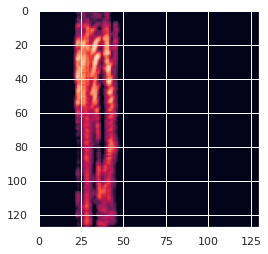

In [62]:
plt.imshow(spec)

In [63]:
train['label'].value_counts()

akasaanyi       92
ensiringanyi    90
munyeera        89
ebigimusa       87
akawuka         85
                ..
sugarcane       12
pumpkin         12
worm            12
beans           12
tomatoes        12
Name: label, Length: 193, dtype: int64

In [64]:
n_folds = 3

In [65]:
train['fold'] = 0

fold = StratifiedKFold(n_splits = n_folds)
for i, (tr, vr) in enumerate(fold.split(train, train['label'])):
  train.loc[vr, 'fold'] = i

In [66]:
sub = pd.read_csv('../input/giz-nlp-agricultural-keyword-spotter/SampleSubmission.csv')
sub.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
birds = sub.columns[1:]
birds

Index(['maize streak virus', 'disease', 'okukkoola', 'muwogo', 'mpeke',
       'mucungwa', 'greens', 'garden', 'mango', 'bulimi',
       ...
       'kasaanyi', 'suckers', 'insects', 'fertilizer', 'nakavundira',
       'ekiwojjolo', 'akawuka', 'ddagala', 'ebiwojjolo', 'obutungulu'],
      dtype='object', length=193)

In [68]:
label = np.linspace(0, len(birds)-1, len(birds), dtype=np.int16)
mapper = dict(zip(birds, label))

In [69]:
train['label'] = train['label'].map(mapper).astype(int)

In [70]:

class AudioDataset(torch.utils.data.Dataset):
  def __init__(self, df, task='train', size=(150, 150), **kwargs):
    super(AudioDataset, self).__init__()
    self.df = df
    self.task = task
    self.size = size
    self.c = len(birds)
    self.classes = birds

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    fn = self.df.loc[idx, 'spec_name']
    try:
        spec = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
        spec = cv2.resize(spec, self.size)
    except Exception as e:
        print(str(e))

    output = {
        'spec': torch.tensor(spec, dtype=torch.float).unsqueeze(0),
    }

    if self.task=='train':
      label = self.df.loc[idx, 'label']
      output.update({'label': torch.tensor( to_categorical(label, self.c), dtype=torch.float ) })

    return output

In [71]:
class AudioModel(torch.nn.Module):
  def __init__(self, arch_name='resnet34', pretrained=True, fc_size=512, out_size=193, **kwargs):
    super(AudioModel, self).__init__()

    self.arch = getattr(models, arch_name)(pretrained)

    head = torch.nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(3,3))
    head.weight = torch.nn.Parameter(self.arch.conv1.weight.sum(dim=1, keepdim=True))

    self.arch.conv1 = head
    self.arch.fc = torch.nn.Linear(fc_size, out_size)
    #self.arch.fc = nn.Sequential(
     #   nn.Linear(fc_size, 4096),
      #  nn.ReLU(inplace=True),
       # nn.Dropout(0.1),
        #nn.Linear(4096,out_size)
        #)

    torch.nn.init.xavier_uniform_(self.arch.fc.weight)

  def forward(self, x):
    x = self.arch(x)
    x = F.sigmoid(x)

    return x

In [72]:

def training_fn(dataloader, model, opt, criterion, epoch):
  avg_loss = 0
  avg_acc = 0
  avg_logloss = 0

  model.train()

  for i, data in enumerate(dataloader):
    x,y = data['spec'].to(device), data['label'].to(device)

    opt.zero_grad()

    pred = model(x)
    loss = criterion(pred, y)

    avg_loss += loss
    avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()
    avg_logloss += multiclass_log_loss(y.cpu().detach().numpy().argmax(1), pred.cpu().detach().numpy())

    loss.backward()
    opt.step()

  avg_loss_nump = avg_loss.cpu().detach().numpy()
  avg_acc_nump = avg_acc.cpu().detach().numpy()
  print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f} - LogLoss {:.5f}'.format(epoch, avg_loss_nump/len(dataloader), avg_acc_nump/len(dataloader),
                                                                        avg_logloss/len(dataloader)))

In [73]:

def evaluate(dataloader, model, criterion):
  avg_loss = 0
  avg_acc = 0
  avg_logloss = 0
  model.eval()

  with torch.no_grad():
    for data in dataloader:
      x = data['spec'].to(device)
      y = data['label'].to(device)

      pred = model(x)
      
      avg_loss += criterion(pred, y)
      avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()
      avg_logloss += multiclass_log_loss(y.cpu().detach().numpy().argmax(1), pred.cpu().detach().numpy())
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)
    avg_logloss /= len(dataloader)

    print('[Evaluation] Loss: {:.5f} - Acc : {:.5f} - LogLoss {:.5f}'.format(avg_loss.cpu().detach().numpy(), 
                                                    avg_acc.cpu().detach().numpy(), avg_logloss))
    
  return avg_logloss

In [74]:
def predict(df, size, bs=2):
  test_ds = AudioDataset(df, task='test', size=size)
  testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

  predictions_labels = []
  predictions_proba = []

  out = None

  for data in tqdm(testloader):
    x = data['spec'].to(device)

    for i in range(n_folds):
      if i == 0: out = MODELS[i](x)
      else: out += MODELS[i](x)

    out /= n_folds
    out_labels = out.argmax(1).cpu().detach().numpy()
    out_probas = out.cpu().detach().numpy()

    predictions_labels += out_labels.tolist()
    predictions_proba += out_probas.tolist()

  return predictions_labels ,predictions_proba

In [75]:
def run_fold(fold, bs=16, eval_bs=8, lr=1e-4, size=(500, 230), arch='resnet34', layer='fc', fc_size=512,  path='MODELS/'):
  best_logloss = np.inf

  fold_train = train[train.fold != fold].reset_index(drop=True)
  fold_val = train[train.fold == fold].reset_index(drop=True)

  train_ds = AudioDataset(fold_train, size=size)
  val_ds = AudioDataset(fold_val, size=size)

  trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
  validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

  model = AudioModel(arch, fc_size=fc_size, layer=layer)
  criterion = torch.nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=lr)
  
  model.to(device)

  loader = tqdm(range(epochs), desc='Training')

  for epoch in loader:
    training_fn(trainloader, model, opt, criterion, epoch)
    avg_logloss = evaluate(validloader, model, criterion)

    if avg_logloss < best_logloss:
      best_logloss = avg_logloss
      torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')

  return best_logloss

In [76]:
epochs = 15
device = 'cuda'
size = (150, 150)
arch='resnet34'
fc_size = 512
bs = 32
lr = 7e-4

In [77]:
avg_logloss = 0
best_fold = 0
fold_logloss = np.inf

for fold in range(n_folds):
  _fold_logloss = run_fold(fold, size=size, arch=arch, fc_size=fc_size, lr=lr, bs=bs)
  avg_logloss += _fold_logloss

  if fold_logloss > _fold_logloss: best_fold = fold

print()
print("Avg LogLoss: ", avg_logloss/n_folds)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Training] Epoch 0 : Loss: 0.04972 - Acc : 0.01198 - LogLoss 5.19157
[Evaluation] Loss: 0.03117 - Acc : 0.02201 - LogLoss 4.93553
[Training] Epoch 1 : Loss: 0.02774 - Acc : 0.08147 - LogLoss 4.34779
[Evaluation] Loss: 0.02587 - Acc : 0.11978 - LogLoss 3.95864
[Training] Epoch 2 : Loss: 0.02160 - Acc : 0.23455 - LogLoss 3.19683
[Evaluation] Loss: 0.02022 - Acc : 0.29600 - LogLoss 2.94183
[Training] Epoch 3 : Loss: 0.01603 - Acc : 0.46202 - LogLoss 2.21508
[Evaluation] Loss: 0.01847 - Acc : 0.36535 - LogLoss 2.55513
[Training] Epoch 4 : Loss: 0.01201 - Acc : 0.62756 - LogLoss 1.56332
[Evaluation] Loss: 0.01407 - Acc : 0.53891 - LogLoss 1.79846
[Training] Epoch 5 : Loss: 0.00884 - Acc : 0.75104 - LogLoss 1.09405
[Evaluation] Loss: 0.01600 - Acc : 0.47926 - LogLoss 2.06540
[Training] Epoch 6 : Loss: 0.00672 - Acc : 0.82554 - LogLoss 0.79292
[Evaluation] Loss: 0.00990 - Acc : 0.69915 - LogLoss 1.22716
[Training] Epoch 7 : Loss: 0.00477 - Acc : 0.89482 - LogLoss 0.53344
[Evaluation] Loss: 0.

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Training] Epoch 0 : Loss: 0.04817 - Acc : 0.01302 - LogLoss 5.20192
[Evaluation] Loss: 0.03076 - Acc : 0.02351 - LogLoss 4.91205
[Training] Epoch 1 : Loss: 0.02782 - Acc : 0.07645 - LogLoss 4.36326
[Evaluation] Loss: 0.02710 - Acc : 0.08060 - LogLoss 4.19363
[Training] Epoch 2 : Loss: 0.02157 - Acc : 0.24134 - LogLoss 3.18818
[Evaluation] Loss: 0.02798 - Acc : 0.12612 - LogLoss 4.22177
[Training] Epoch 3 : Loss: 0.01598 - Acc : 0.45810 - LogLoss 2.20961
[Evaluation] Loss: 0.01710 - Acc : 0.42516 - LogLoss 2.37983
[Training] Epoch 4 : Loss: 0.01180 - Acc : 0.62876 - LogLoss 1.53446
[Evaluation] Loss: 0.01668 - Acc : 0.41914 - LogLoss 2.29106
[Training] Epoch 5 : Loss: 0.00894 - Acc : 0.75497 - LogLoss 1.09871
[Evaluation] Loss: 0.01192 - Acc : 0.62122 - LogLoss 1.53681
[Training] Epoch 6 : Loss: 0.00640 - Acc : 0.84060 - LogLoss 0.74742
[Evaluation] Loss: 0.01325 - Acc : 0.57313 - LogLoss 1.70354
[Training] Epoch 7 : Loss: 0.00457 - Acc : 0.90339 - LogLoss 0.50738
[Evaluation] Loss: 0.

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Training] Epoch 0 : Loss: 0.05163 - Acc : 0.01480 - LogLoss 5.18958
[Evaluation] Loss: 0.03113 - Acc : 0.03097 - LogLoss 4.84409
[Training] Epoch 1 : Loss: 0.02762 - Acc : 0.07055 - LogLoss 4.32562
[Evaluation] Loss: 0.02686 - Acc : 0.08172 - LogLoss 4.13318
[Training] Epoch 2 : Loss: 0.02185 - Acc : 0.22763 - LogLoss 3.23833
[Evaluation] Loss: 0.02516 - Acc : 0.13632 - LogLoss 3.69513
[Training] Epoch 3 : Loss: 0.01642 - Acc : 0.43373 - LogLoss 2.27904
[Evaluation] Loss: 0.02425 - Acc : 0.21555 - LogLoss 3.24245
[Training] Epoch 4 : Loss: 0.01208 - Acc : 0.62149 - LogLoss 1.57393
[Evaluation] Loss: 0.01515 - Acc : 0.48744 - LogLoss 2.02688
[Training] Epoch 5 : Loss: 0.00887 - Acc : 0.75090 - LogLoss 1.09833
[Evaluation] Loss: 0.01249 - Acc : 0.60037 - LogLoss 1.58087
[Training] Epoch 6 : Loss: 0.00661 - Acc : 0.83355 - LogLoss 0.77049
[Evaluation] Loss: 0.01152 - Acc : 0.63470 - LogLoss 1.45506
[Training] Epoch 7 : Loss: 0.00472 - Acc : 0.89902 - LogLoss 0.52825
[Evaluation] Loss: 0.

In [78]:
sub = pd.read_csv('../input/giz-nlp-agricultural-keyword-spotter/SampleSubmission.csv')
sub.head()


,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
import re

def clean_text(text):
    text = re.sub(r'audio_files/', '../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files/', text) # Remove path 
    return text
sub['fn'] = sub['fn'].apply(lambda x: clean_text(x))
sub.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Add file names
sub['spec_name'] = './Imgs/Test'+sub['fn']+'.png'
#sub['spec_name'] = 'Imgs/Test/'+sub['ID']+'.png'

def clean_text(text):
    text = re.sub(r'./Imgs/Test../input/giz-nlp-agricultural-keyword-spotter/audio_files/audio_files', './Imgs/Test/', text) # Remove path
    text = re.sub(r'.wav.png', '.png', text) # Remove path
    return text
sub['spec_name'] = sub['spec_name'].apply(lambda x: clean_text(x))
sub.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu,spec_name
0,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,./Imgs/Test//00118N3.png
1,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,./Imgs/Test//00P0NMV.png
2,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,./Imgs/Test//01QEEZI.png
3,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,./Imgs/Test//037YAED.png
4,../input/giz-nlp-agricultural-keyword-spotter/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,./Imgs/Test//0382N0Y.png


In [81]:
#Test specs
for row in tqdm(sub.values):
  sound_path = row[0] #this corresponds to 'file_name'
  spec_name = row[194] #this corresponds to 'spec_name'

  spec = melspectogram_dB(sound_path, 3)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)

In [82]:
MODELS = []
for i in range(n_folds):
  MODELS.append( AudioModel(arch_name=arch, fc_size=fc_size) )
  MODELS[i].to(device)
  MODELS[i].load_state_dict(torch.load(f'MODELS/model_state_dict_{i}.bin'))
  MODELS[i].eval()

In [83]:

predictions_labels, predictions_proba = predict(sub, size=size, bs=2)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [84]:
sub = pd.read_csv('../input/giz-nlp-agricultural-keyword-spotter/SampleSubmission.csv')
sub.head()


,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:

submission = pd.DataFrame()
submission['fn'] = sub['fn']
for i, label in enumerate(birds):
  submission[label] = 0
for i, label in enumerate(birds):
  submission.loc[:,label] = np.array(predictions_proba)[:,i]

In [86]:
submission.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0.000205,0.000049,0.000345,1.052588e-04,0.000598,0.000042,0.000103,0.000158,0.000110,...,0.000039,0.000098,0.000092,0.000034,0.000015,6.289715e-05,0.001745,0.000152,0.000044,0.000052
1,audio_files/00P0NMV.wav,0.000010,0.000017,0.000002,1.343754e-06,0.000018,0.000042,0.000070,0.000009,0.000003,...,0.000010,0.000011,0.000006,0.000326,0.904171,9.287288e-05,0.000045,0.000017,0.000001,0.000017
2,audio_files/01QEEZI.wav,0.000105,0.000408,0.000065,2.579638e-02,0.000401,0.000046,0.000083,0.000017,0.000214,...,0.000008,0.000006,0.000134,0.000038,0.000005,6.575906e-05,0.000005,0.000009,0.000445,0.000160
3,audio_files/037YAED.wav,0.000052,0.000005,0.000047,5.105077e-07,0.001658,0.000009,0.000023,0.283096,0.000003,...,0.000141,0.003890,0.000005,0.000727,0.000005,9.992884e-07,0.000008,0.000117,0.000025,0.000026
4,audio_files/0382N0Y.wav,0.000057,0.000091,0.000392,1.414089e-04,0.000073,0.000008,0.000020,0.000015,0.000090,...,0.000033,0.000020,0.000032,0.000043,0.000020,8.860276e-05,0.000011,0.000016,0.000561,0.000024


In [87]:
submission.describe()

,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,bulimi,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
count,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,...,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03,1.017000e+03
mean,1.675696e-03,1.139085e-03,3.032649e-03,2.897391e-03,3.904461e-03,3.220871e-03,5.239586e-04,4.828263e-03,8.258713e-04,3.206424e-03,...,6.254715e-03,4.152431e-03,1.902019e-03,1.563933e-03,4.822467e-03,7.165176e-03,7.968187e-03,3.557396e-03,7.045370e-03,1.971860e-03
std,3.024668e-02,1.705248e-02,3.792138e-02,4.404132e-02,3.246526e-02,4.235873e-02,3.339828e-03,5.135065e-02,8.810793e-03,3.751670e-02,...,6.206097e-02,5.532926e-02,2.480130e-02,3.161635e-02,6.066464e-02,6.669067e-02,7.972788e-02,4.500850e-02,6.338846e-02,2.266313e-02
min,4.841650e-07,3.729226e-07,1.230769e-07,2.500740e-08,5.418765e-08,2.871300e-08,8.641500e-07,1.333593e-07,6.203799e-08,8.195052e-08,...,5.346600e-08,1.796576e-07,1.172074e-07,6.804741e-08,6.850183e-08,2.341853e-08,7.180164e-08,2.467562e-07,8.134227e-09,3.651711e-08
25%,2.519358e-05,7.444221e-06,5.371697e-06,2.198341e-06,8.039515e-06,3.791926e-06,1.467545e-05,9.062412e-06,4.644377e-06,5.077759e-06,...,5.698125e-06,6.479010e-06,6.140107e-06,4.670506e-06,4.062221e-06,3.482799e-06,3.273578e-06,6.458300e-06,3.218856e-06,4.132007e-06
50%,6.453493e-05,1.907024e-05,2.041901e-05,1.431016e-05,5.050788e-05,1.875969e-05,4.266154e-05,3.132081e-05,1.691427e-05,1.895673e-05,...,2.014771e-05,1.837283e-05,2.226828e-05,1.583654e-05,1.904054e-05,1.697626e-05,1.803374e-05,2.065496e-05,1.687810e-05,2.085081e-05
75%,2.155721e-04,7.346977e-05,1.134660e-04,9.026004e-05,2.899733e-04,1.012061e-04,1.267801e-04,1.522116e-04,6.862636e-05,8.245061e-05,...,9.415914e-05,7.731254e-05,1.029982e-04,5.651492e-05,1.087659e-04,1.212682e-04,1.103561e-04,9.115878e-05,1.014853e-04,8.787433e-05
max,7.679867e-01,4.999302e-01,9.074426e-01,9.903024e-01,8.175691e-01,9.678316e-01,5.929682e-02,8.348190e-01,2.315349e-01,7.404313e-01,...,9.662904e-01,9.802944e-01,5.712246e-01,8.851531e-01,9.874635e-01,9.928656e-01,9.956094e-01,9.860162e-01,8.901915e-01,4.378337e-01


In [88]:
submission.to_csv(f'aug_cst_3_SIZE_{size}_arch_{arch}_folds_{n_folds}_epochs_{epochs}_bs_{bs}.csv', index=False)